In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.gridspec import GridSpec 
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from scipy.integrate import odeint

In [2]:
def Rössler(x0, a, b, c, t):
    def dynamical_system(y,t):
        dy = np.zeros_like(y)
        dy[0] = -y[1]-y[2]
        dy[1] = y[0] + a*y[1]
        dy[2] = b + y[2]*(y[0]-c)
        return dy
    x = odeint(dynamical_system, x0, t, rtol=1e-12, atol=1e-12)
    dt = t[1] - t[0]
    xdot = np.gradient(x, dt, axis=0)
    return x, xdot

In [3]:
#chaotic parameters
a, b, c = 0.2, 0.2, 5.7
t = np.arange(0, 100, 0.01)
x0 = np.array([0, 0, 0])
x, dx = Rössler(x0, a, b, c, t)

Text(0.5, 0, 'z')

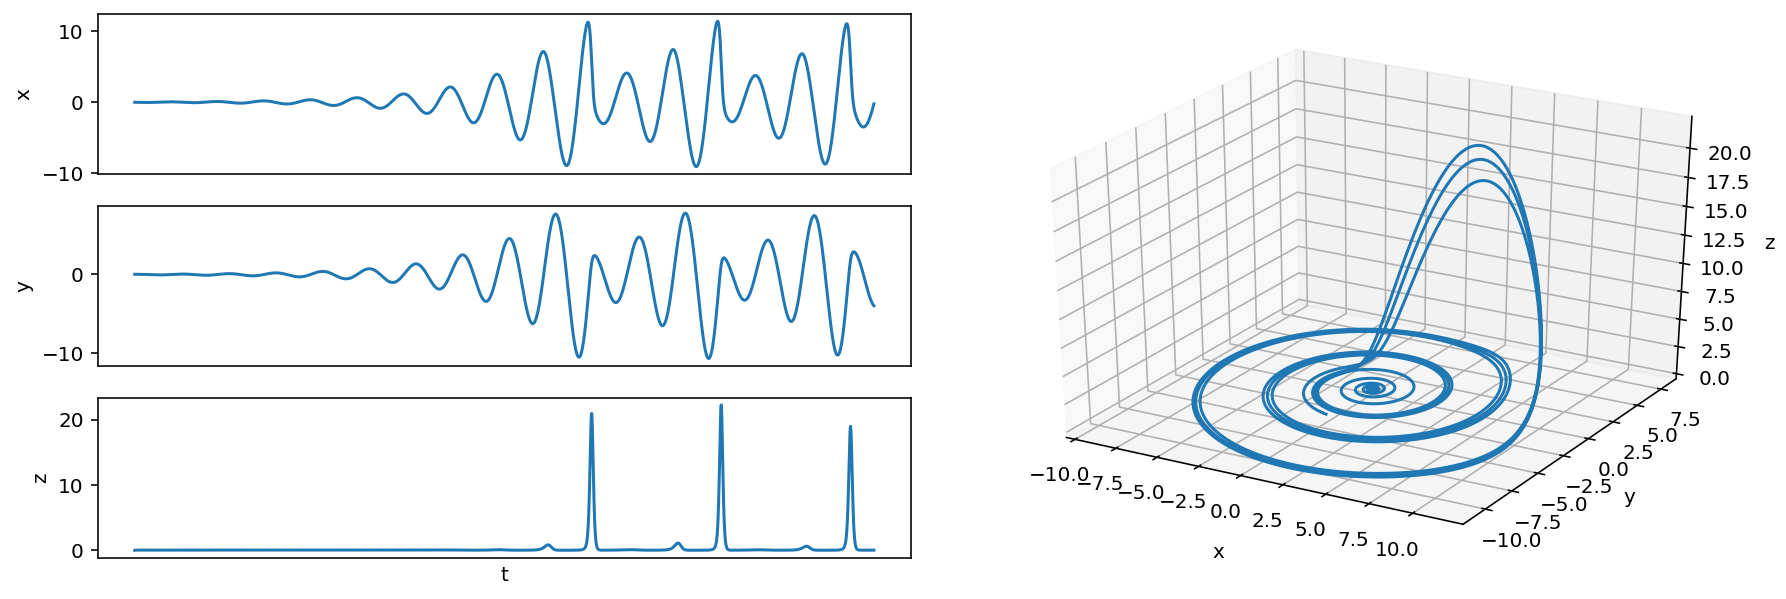

In [4]:
w = 10
fig = plt.figure(figsize=(1.5*w, w/2))
gs = GridSpec(3, 6)

ax0 = fig.add_subplot(gs[0, :3])
ax0.plot(t, x[:, 0])
ax0.set_ylabel('x')
ax0.set_xticks([])
#ax0.set_xlim(0, 20)

ax1 = fig.add_subplot(gs[1, :3])
ax1.plot(t, x[:, 1])
ax1.set_ylabel('y')
ax1.set_xticks([])
#ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs[2, :3])
ax2.plot(t, x[:, 2])
ax2.set_ylabel('z')
ax2.set_xlabel('t')
ax2.set_xticks([])
#ax2.set_xlim(0, 20)

ax3 = fig.add_subplot(gs[:, 3:], projection='3d')
ax3.plot(x[:, 0], x[:, 1], x[:, 2])
ax3.set_xlabel('x', labelpad=10)
ax3.set_ylabel('y')
ax3.set_zlabel('z')

In [5]:
# Non-linear function library
library = PolynomialFeatures(degree=5, include_bias=True)
# include_bias parameter is for the feature in which all polynomial powers are zero - column of ones
Theta = library.fit_transform(x)
n_lib = library.n_output_features_

In [6]:
%time
threshold = 0.005
x_new = np.linalg.lstsq(Theta, dx, rcond=None)[0] #initial guess 
for k in range(10):
    small_indices = np.abs(x_new) < threshold
    x_new[small_indices] = 0
    for i in range(3):
        big_indices = ~small_indices[:,i]
        x_new[big_indices,i] = np.linalg.lstsq(Theta[:,big_indices], dx[:,i], rcond=None)[0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [7]:
x_ht = pd.DataFrame(data=x_new, columns=('x0','x1','x2'), index=library.get_feature_names())
print('Total number of possible coefficients:', x_new.size)
print('Number of non-zero coefficients:', np.count_nonzero(x_new))

Total number of possible coefficients: 168
Number of non-zero coefficients: 7


In [8]:
x_ht.head(n=7)

,x0,x1,x2
1,0.000000,0.000000,0.199893
x0,0.000000,0.999977,0.000000
x1,-0.999981,0.199996,0.000000
x2,-0.999837,0.000000,-5.696954
x0^2,0.000000,0.000000,0.000000
x0 x1,0.000000,0.000000,0.000000
x0 x2,0.000000,0.000000,0.999466


In [9]:
def sindy_model(x,t,library,coeffs):
    dxdt = np.zeros_like(x)
    library = PolynomialFeatures(degree=5, include_bias=True)
    Theta = library.fit_transform(x.reshape(1,-1))
    dxdt = np.dot(Theta, coeffs)
    return dxdt.flatten()

In [10]:
x_hst = odeint(sindy_model, x0, t, args=(library, x_new))

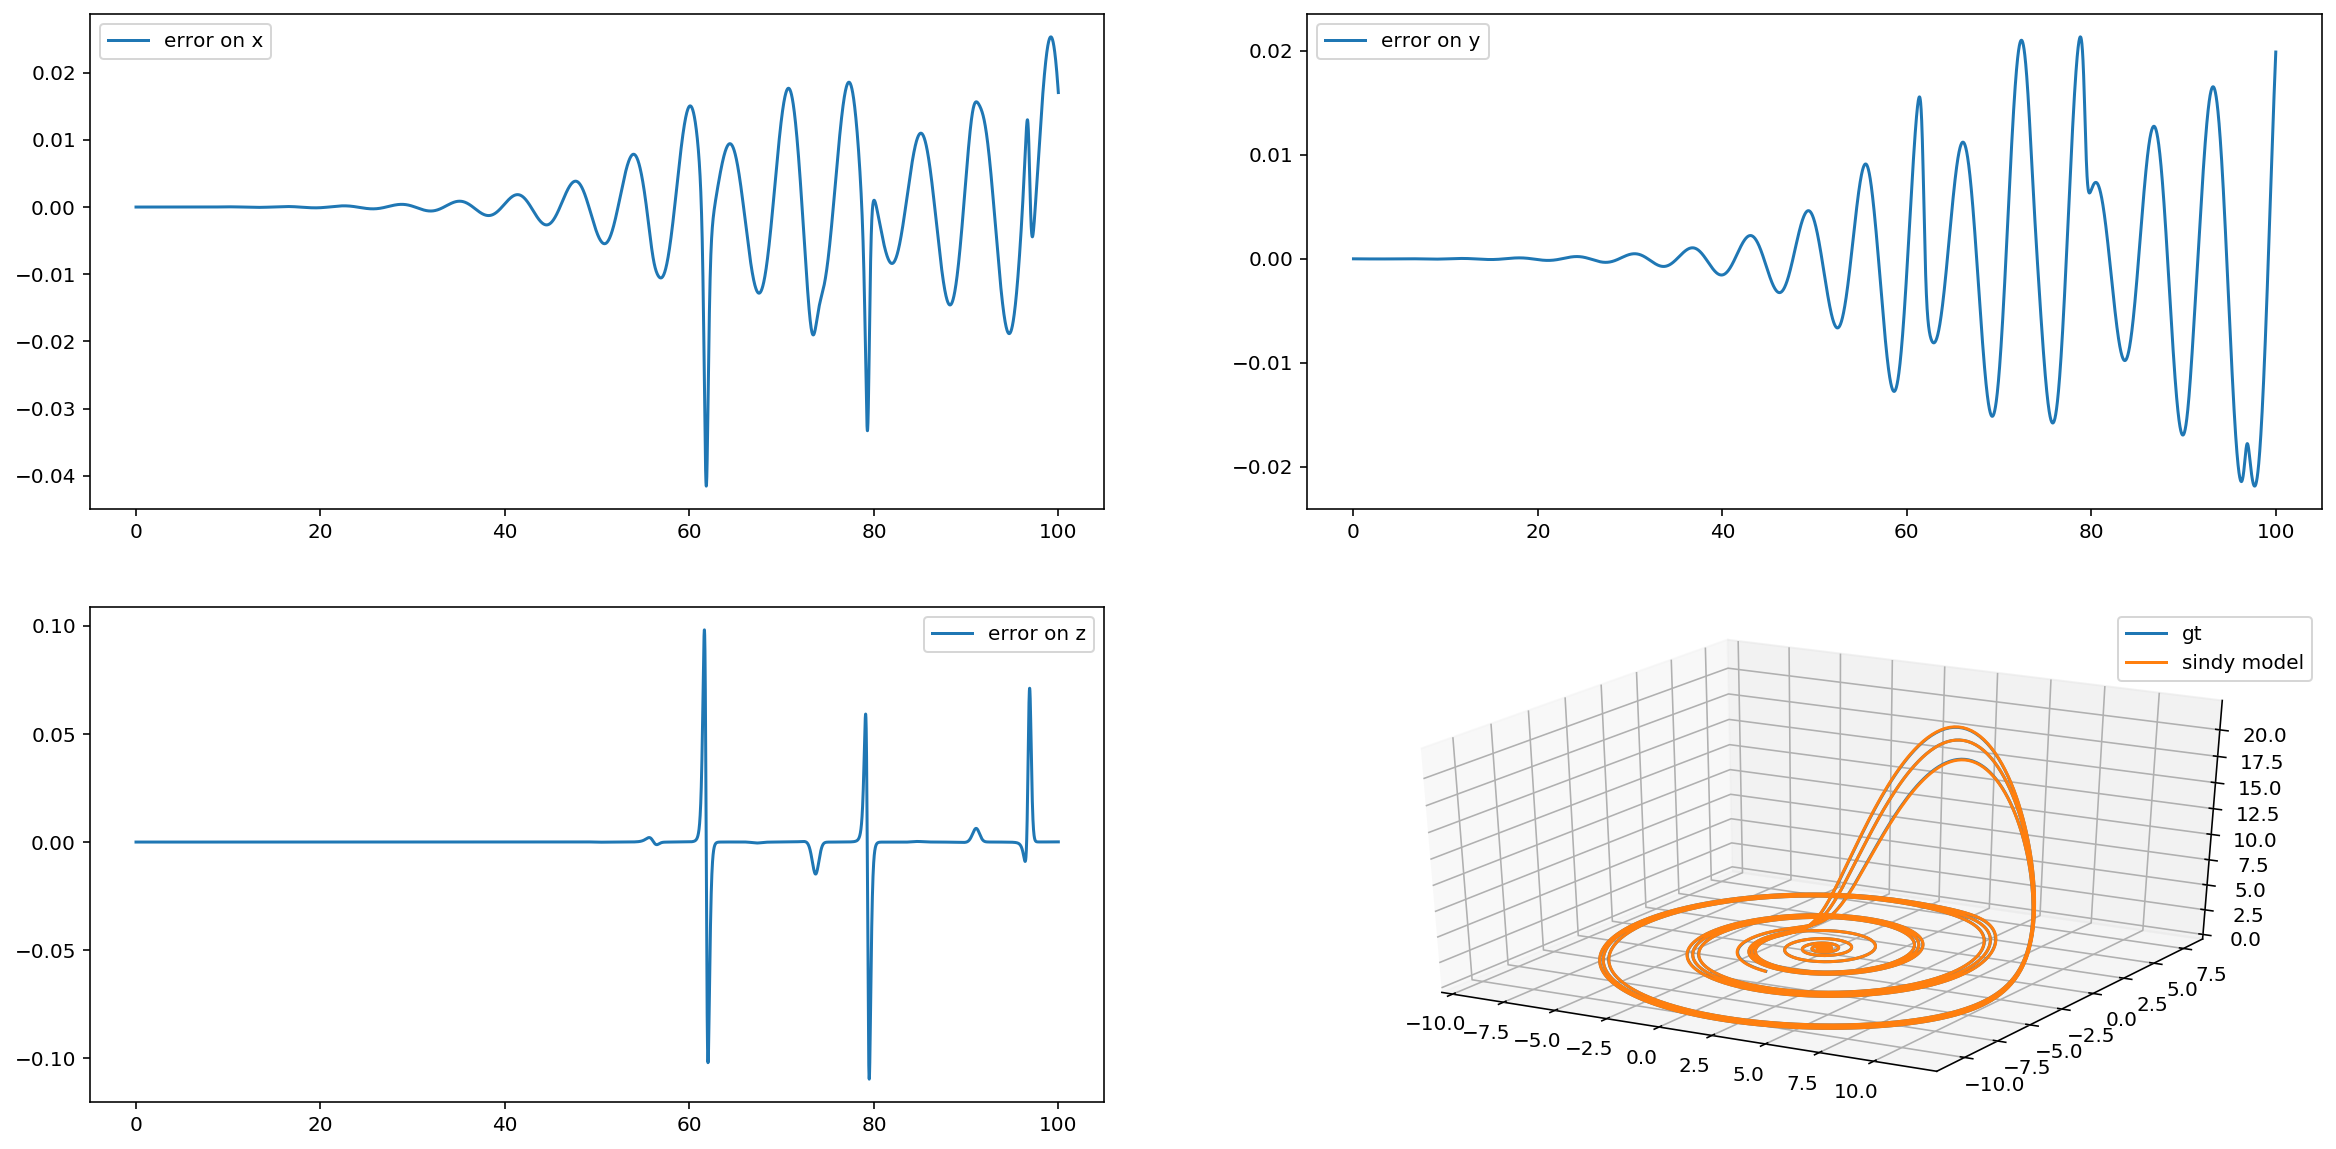

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.plot(t, x[:,0]-x_hst[:,0], label='error on x')
plt.legend()
plt.subplot(222)
plt.plot(t, x[:,1]-x_hst[:,1], label='error on y')
plt.legend()
plt.subplot(223)
plt.plot(t, x[:,2]-x_hst[:,2], label='error on z')
plt.legend()
plt.subplot(224, projection='3d')
plt.plot(x[:,0], x[:,1], x[:,2], label='gt')
plt.plot(x_hst[:,0], x_hst[:,1], x_hst[:,2], label='sindy model')
plt.legend()